<a href="https://colab.research.google.com/github/makaronaaa/DataSciencePython/blob/main/ARIMA_UseCase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [198]:
import pandas as pd
df=pd.read_csv(r'/content/sample_data/CaseStudyData.csv', encoding='utf-8')

In [199]:
print(df[df.reported_sales_yoy.isnull()])

   entity                      company  \
13   TXRH         Texas Roadhouse Inc.   
27    EAT  Brinker International, Inc.   
42    DRI     Darden Restaurants, Inc.   

                                      metric period_end_dt reported_sales_yoy  
13         US Company-Owned Restaurant Sales    12/29/2020                NaN  
27         US Company-Owned Restaurant Sales    12/23/2020                NaN  
42  Reported Total Revenue (ex. Red Lobster)    11/29/2020                NaN  


In [200]:
df['sales_yoy_float'] = df['reported_sales_yoy'].str.strip('%').astype(float)
#df

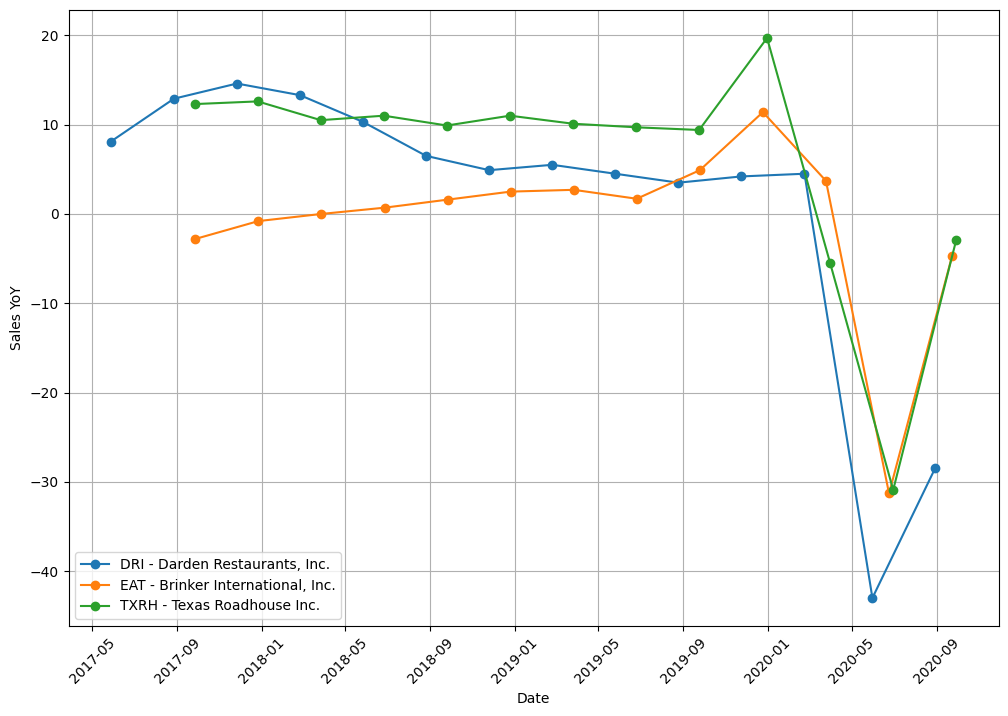

In [201]:
import matplotlib.pyplot as plt
import pandas as pd

df['period_end_dt'] = pd.to_datetime(df['period_end_dt'])
grouped = df.groupby(['entity', 'company'])
plt.figure(figsize=(12, 8))
for (entity, company), group_data in grouped:
    plt.plot(group_data['period_end_dt'], group_data['sales_yoy_float'], marker='o', linestyle='-', label=f'{entity} - {company}')
plt.xticks(rotation=45)
plt.xlabel('Date') 
plt.ylabel('Sales YoY')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

## No noticable seasonality. Hence we can use ARIMA.
## Very volatile after 2019 due presumably due to Covid-19 Lockdown.

In [202]:
df.describe()

,sales_yoy_float
count,40.00000
mean,2.19750
std,13.37927
min,-43.00000
25%,0.52500
50%,4.70000
75%,10.35000
max,19.70000


In [203]:
df = df[['entity', 'period_end_dt', 'sales_yoy_float']]
df.columns = ['entity' , 'period_end_dt', 'sales_yoy_float']
# df.head()

df=df.dropna()

Auto Regressive **Model**

In [204]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import matplotlib.pyplot as plt

In [205]:
df_DRI = df[df['entity'] == "DRI"]
df_DRI["sales_yoy_float"]

# df = df[['entity', 'period_end_dt', 'sales_yoy_float']]
# df.columns = ['entity' , 'period_end_dt', 'sales_yoy_float']
# # df.head()
# df_DRI = df[['period_end_dt', 'sales_yoy_float']][df['entity'] == 'DRI']
# # df_DRI.drop(42,axis=0, inplace=True)

# # df_DRI.set_index('period_end_dt', inplace=True)
df_DRI

,entity,period_end_dt,sales_yoy_float
28,DRI,2017-05-28,8.1
29,DRI,2017-08-27,12.9
30,DRI,2017-11-26,14.6
31,DRI,2018-02-25,13.3
32,DRI,2018-05-27,10.3
33,DRI,2018-08-26,6.5
34,DRI,2018-11-25,4.9
35,DRI,2019-02-24,5.5
36,DRI,2019-05-26,4.5
37,DRI,2019-08-25,3.5


In [206]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df_DRI["sales_yoy_float"].dropna())
test_result

(3.131213191626794,
 1.0,
 5,
 8,
 {'1%': -4.6651863281249994, '5%': -3.3671868750000002, '10%': -2.802960625},
 52.26989414166469)

In [207]:
def adfuller_test(df_DRI):
    result=adfuller(df_DRI)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")


In [208]:
adfuller_test(df_DRI['sales_yoy_float'])

ADF Test Statistic : 3.131213191626794
p-value : 1.0
#Lags Used : 5
Number of Observations Used : 8
Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary 


Differencing df_DRI

In [209]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def adfuller_test(df_DRI):
    # Perform differencing
    df_DRI_diff = df_DRI.diff().dropna()  # Differencing the series
    
    result = adfuller(df_DRI_diff)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))

    if result[1] <= 0.05:
        print("P value is less than 0.05, which means we can reject the null hypothesis (Ho).")
        print("Therefore, we can conclude that the differenced data is stationary.")
    else:
        print("Weak evidence against the null hypothesis, which indicates that the differenced time series still has a unit root and is non-stationary.")

# Assuming df_DRI['sales_yoy_float'] is the original non-stationary time series
adfuller_test(df_DRI['sales_yoy_float'])


ADF Test Statistic : -1.9574522059192776
p-value : 0.3055345827321506
#Lags Used : 4
Number of Observations Used : 8
Weak evidence against the null hypothesis, which indicates that the differenced time series still has a unit root and is non-stationary.


In [210]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform iterative differencing to make the series stationary and save to a new column
def make_stationary(df_DRI, column_name):
    series=df_DRI["sales_yoy_float"]
    df_diff = series.copy()
    num_diffs = 0
    
    while True:
        df_diff = df_diff.diff().dropna()
        num_diffs += 1
        
        test_result = adfuller(df_diff)
        p_value = test_result[1]
        
        if p_value <= 0.05:
            print("Number of Differences:", num_diffs)
            print("P-value is less than or equal to 0.05, which means we can reject the null hypothesis (Ho).")
            break
    
    # Create a new column with the differenced values
    new_column_name = column_name + "_diff"
    df[new_column_name] = df_diff
    
    return df

# Assuming df_DRI is "DIFF" is the column with non-stationary values
df_DRI = make_stationary(df_DRI, "DIFF")

# Perform the ADF test on the differenced series in the new column
adfuller_test(df_DRI["DIFF_diff"])

Number of Differences: 4
P-value is less than or equal to 0.05, which means we can reject the null hypothesis (Ho).
ADF Test Statistic : -6.608771011818328
p-value : 6.455843875200966e-09
#Lags Used : 2
Number of Observations Used : 6
P value is less than 0.05, which means we can reject the null hypothesis (Ho).
Therefore, we can conclude that the differenced data is stationary.


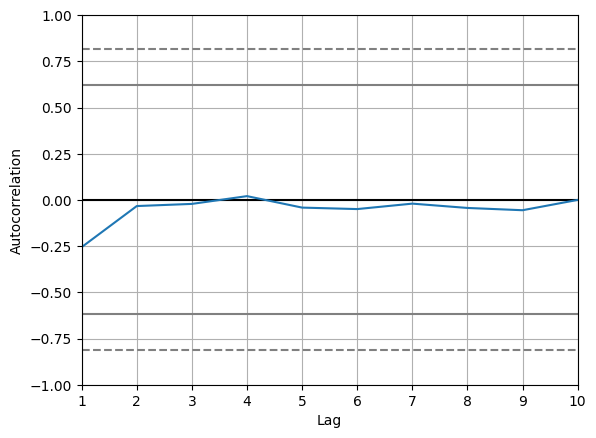

In [211]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_DRI["DIFF_diff"].dropna())
plt.show()

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.

In [212]:
# For non-seasonal data
#p=1 (AR specification), d=1 (Integration order), q=0 or 1 (MA specification/polynomial)AR specification, Integration order, MA specification
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
model_DRI = ARIMA(df_DRI["DIFF_diff"].values, order=(1, 0, 1))
model_DRI_fitted = model_DRI.fit()
model_DRI_fitted.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   40
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -49.409
Date:                Mon, 15 May 2023   AIC                            106.817
Time:                        18:53:44   BIC                            113.573
Sample:                             0   HQIC                           109.260
                                 - 40                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7427      4.893      0.152      0.879      -8.847      10.333
ar.L1         -0.8624      0.316     -2.727      0.006      -1.482      -0.243
ma.L1         -0.9928     32.675     -0.030      0.976     -65.034      63.048
sigma2       705.3579   2.29e+04      0.031      0.975   -4.42e+04    4.56e+04
===================================================================================
Ljung-Box (L1) (Q):                   7.55   Jarque-Bera (JB):               479.39
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):                inf   Skew:                             1.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

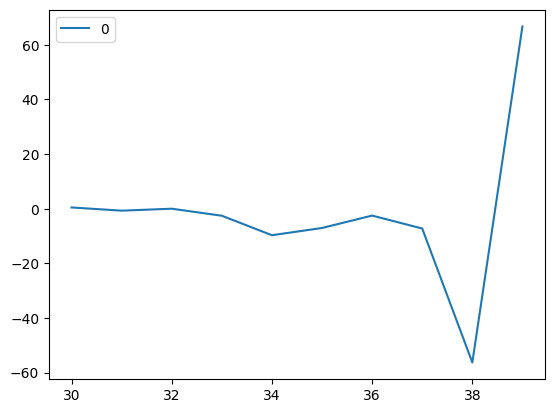

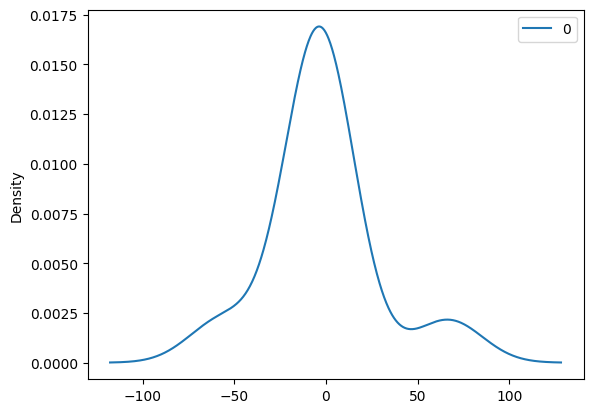

               0
count  10.000000
mean   -1.895684
std    29.441518
min   -56.320964
25%    -7.209692
50%    -2.545988
75%    -0.178685
max    66.742886


In [213]:
from matplotlib import pyplot
residuals = pd.DataFrame(model_DRI_fitted.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [214]:
model_DRI_fitted.predict(start=len(df_DRI), end=len(df_DRI))

array([-194.38211353])

**EAT**

In [215]:
# df_EAT = df[df['entity'] == "EAT"]
# df_EAT["sales_yoy_float"]

df = df[['entity', 'period_end_dt', 'sales_yoy_float']]
df.columns = ['entity' , 'period_end_dt', 'sales_yoy_float']
# df.head()

df_EAT = df[['period_end_dt', 'sales_yoy_float']][df['entity'] == 'EAT']
# df_EAT.drop(27,axis=0, inplace=True)
# df_EAT.set_index('period_end_dt', inplace=True)
df_EAT

,period_end_dt,sales_yoy_float
14,2017-09-27,-2.8
15,2017-12-27,-0.8
16,2018-03-28,0.0
17,2018-06-27,0.7
18,2018-09-26,1.6
19,2018-12-26,2.5
20,2019-03-27,2.7
21,2019-06-26,1.7
22,2019-09-25,4.9
23,2019-12-25,11.4


In [216]:
test_result=adfuller(df_EAT["sales_yoy_float"].dropna())
test_result

(-2.558862768322151,
 0.1018009999721956,
 3,
 9,
 {'1%': -4.473135048010974,
  '5%': -3.28988060356653,
  '10%': -2.7723823456790124},
 23.749314437249655)

In [217]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
#Ho: It is non stationary
#H1: It is stationary
# Perform the ADF test
def adfuller_test(df):
    
    adf_statistic = test_result[0]
    p_value = test_result[1]
    num_lags = test_result[2]
    num_observations = test_result[3]
    
    print("ADF Test Statistic:", adf_statistic)
    print("p-value:", p_value)
    print("#Lags Used:", num_lags)
    print("Number of Observations Used:", num_observations)
    
    if p_value <= 0.05:
        print("P-value is less than or equal to 0.05, which means we can reject the null hypothesis (Ho).")
        print("Therefore, we can conclude that the data has no unit root and is stationary.")
    else:
        print("Weak evidence against the null hypothesis, which indicates that the time series has a unit root.")
        print("This suggests that the data is non-stationary.")


adfuller_test(df_EAT["sales_yoy_float"])


ADF Test Statistic: -2.558862768322151
p-value: 0.1018009999721956
#Lags Used: 3
Number of Observations Used: 9
Weak evidence against the null hypothesis, which indicates that the time series has a unit root.
This suggests that the data is non-stationary.


**Differencing**

In [218]:
adfuller_test(test_result)

ADF Test Statistic: -2.558862768322151
p-value: 0.1018009999721956
#Lags Used: 3
Number of Observations Used: 9
Weak evidence against the null hypothesis, which indicates that the time series has a unit root.
This suggests that the data is non-stationary.


In [219]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def make_stationary(series):
    df_diff = series.copy()
    num_diffs = 0

    while True:
        df_diff = df_diff.diff().dropna(axis=0)
        num_diffs += 1

        test_result = adfuller(df_diff)
        p_value = test_result[1]

        if p_value <= 0.05:
            print("Number of Differences:", num_diffs)
            print("P-value is less than or equal to 0.05, which means we can reject the null hypothesis (Ho).")
            print("Therefore, we can conclude that the differenced data has no unit root and is stationary.")
            break

    return df_diff

# Assuming df_EAT is a DataFrame containing the "sales_yoy_float" column
df_EAT = df[['period_end_dt', 'sales_yoy_float']][df['entity'] == 'EAT']
stationary_series = make_stationary(df_EAT["sales_yoy_float"])
df_EAT["stationary_sales"] = stationary_series

Number of Differences: 2
P-value is less than or equal to 0.05, which means we can reject the null hypothesis (Ho).
Therefore, we can conclude that the differenced data has no unit root and is stationary.


In [220]:
df_EAT

,period_end_dt,sales_yoy_float,stationary_sales
14,2017-09-27,-2.8,NaN
15,2017-12-27,-0.8,NaN
16,2018-03-28,0.0,-1.200000e+00
17,2018-06-27,0.7,-1.000000e-01
18,2018-09-26,1.6,2.000000e-01
19,2018-12-26,2.5,-2.220446e-16
20,2019-03-27,2.7,-7.000000e-01
21,2019-06-26,1.7,-1.200000e+00
22,2019-09-25,4.9,4.200000e+00
23,2019-12-25,11.4,3.300000e+00


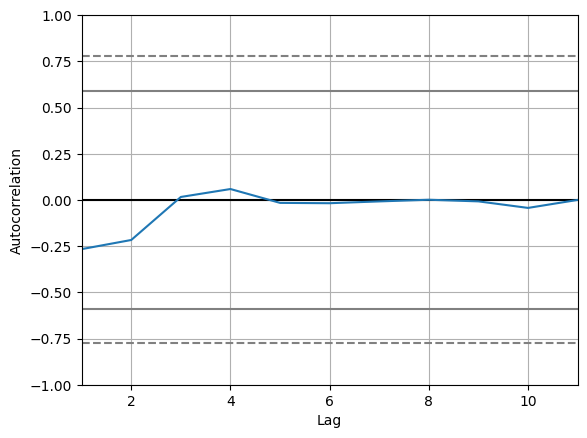

In [221]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_EAT["stationary_sales"].dropna())
plt.show()

looking at plot we can conclude no seasonality

In [223]:
model_EAT = ARIMA(df_EAT["stationary_sales"].values, order=(1, 0, 1))
model_EAT_fitted = model_EAT.fit()
model_EAT_fitted.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   13
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -44.451
Date:                Mon, 15 May 2023   AIC                             96.902
Time:                        18:54:05   BIC                             99.162
Sample:                             0   HQIC                            96.438
                                 - 13                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8027      1.327     -0.605      0.545      -3.404       1.798
ar.L1         -0.5952      0.810     -0.735      0.462      -2.182       0.991
ma.L1         -0.9983    103.575     -0.010      0.992    -204.001     202.005
sigma2       134.4168   1.39e+04      0.010      0.992   -2.71e+04    2.74e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.15   Jarque-Bera (JB):                21.41
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):           12451.06   Skew:                            -2.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

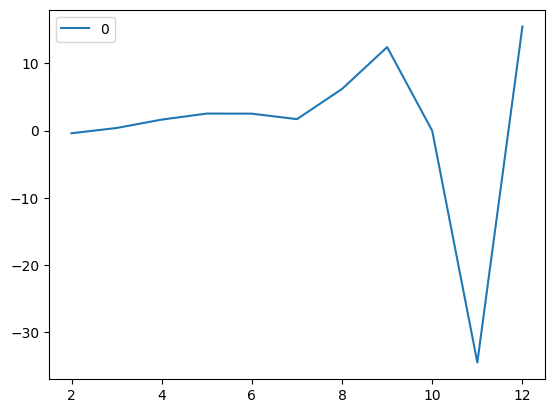

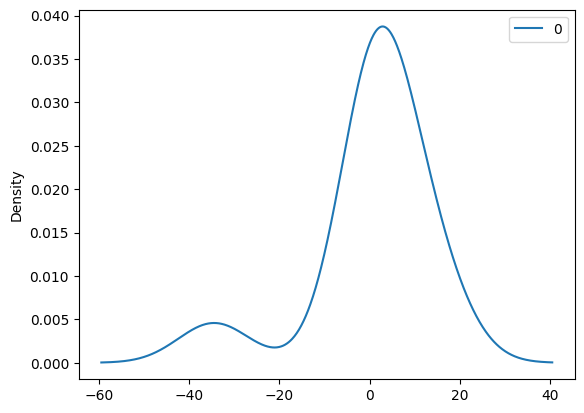

               0
count  11.000000
mean    0.722017
std    12.791460
min   -34.505524
25%     0.173796
50%     1.702154
75%     4.364293
max    15.491310


In [224]:
from matplotlib import pyplot
residuals = pd.DataFrame(model_EAT_fitted.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


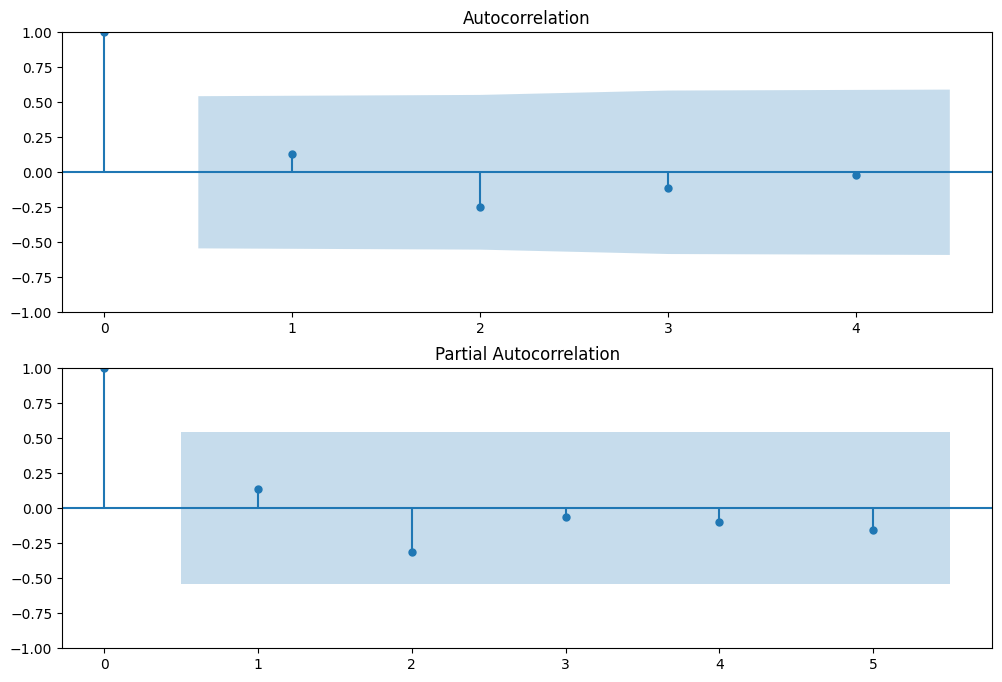

In [225]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_EAT['sales_yoy_float'], lags=4, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_EAT['sales_yoy_float'], lags=5, ax=ax2)

In [226]:
model_EAT_fitted.predict(start=len(df_EAT), end=len(df_EAT))

array([-52.05968591])

**TXRH**

In [227]:
# df_TXRH = df[df['entity'] == "TXRH"]
# df_TXRH["sales_yoy_float"]


df = df[['entity', 'period_end_dt', 'sales_yoy_float']]
df.columns = ['entity' , 'period_end_dt', 'sales_yoy_float']
# df.head()

TXRH = df[['period_end_dt', 'sales_yoy_float']][df['entity'] == 'TXRH']
# TXRH.drop(13,axis=0, inplace=True)
# TXRH.set_index('period_end_dt', inplace=True)
TXRH 

,period_end_dt,sales_yoy_float
0,2017-09-26,12.3
1,2017-12-26,12.6
2,2018-03-27,10.5
3,2018-06-26,11.0
4,2018-09-25,9.9
5,2018-12-25,11.0
6,2019-03-26,10.1
7,2019-06-25,9.7
8,2019-09-24,9.4
9,2019-12-31,19.7


In [228]:
import numpy as np
from statsmodels.tsa.stattools import adfuller

test_result=adfuller(TXRH["sales_yoy_float"].dropna())
test_result


(-3.317130971011193,
 0.014129871289370712,
 1,
 11,
 {'1%': -4.223238279489106,
  '5%': -3.189368925619835,
  '10%': -2.729839421487603},
 65.16470345538909)

In [229]:

import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

#Ho: It is non stationary
#H1: It is stationary
# Perform the ADF test
def adfuller_test(df):
    
    adf_statistic = test_result[0]
    p_value = test_result[1]
    num_lags = test_result[2]
    num_observations = test_result[3]
    
    print("ADF Test Statistic:", adf_statistic)
    print("p-value:", p_value)
    print("#Lags Used:", num_lags)
    print("Number of Observations Used:", num_observations)
    
    if p_value <= 0.05:
        print("P-value is less than or equal to 0.05, which means we can reject the null hypothesis (Ho).")
        print("Therefore, we can conclude that the data has no unit root and is stationary.")
    else:
        print("Weak evidence against the null hypothesis, which indicates that the time series has a unit root.")
        print("This suggests that the data is non-stationary.")


adfuller_test(TXRH["sales_yoy_float"])

ADF Test Statistic: -3.317130971011193
p-value: 0.014129871289370712
#Lags Used: 1
Number of Observations Used: 11
P-value is less than or equal to 0.05, which means we can reject the null hypothesis (Ho).
Therefore, we can conclude that the data has no unit root and is stationary.


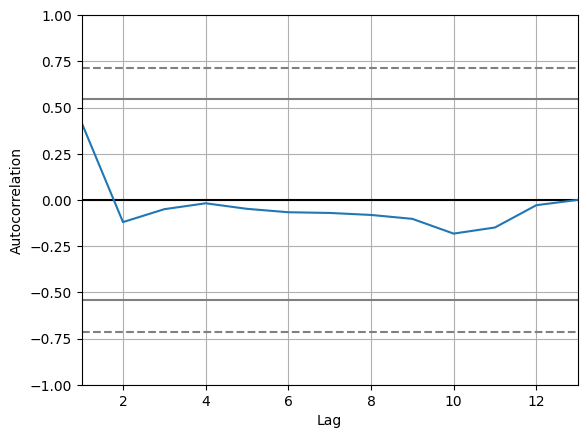

In [230]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(TXRH["sales_yoy_float"])
plt.show()

plot shows slight seasonality

In [231]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


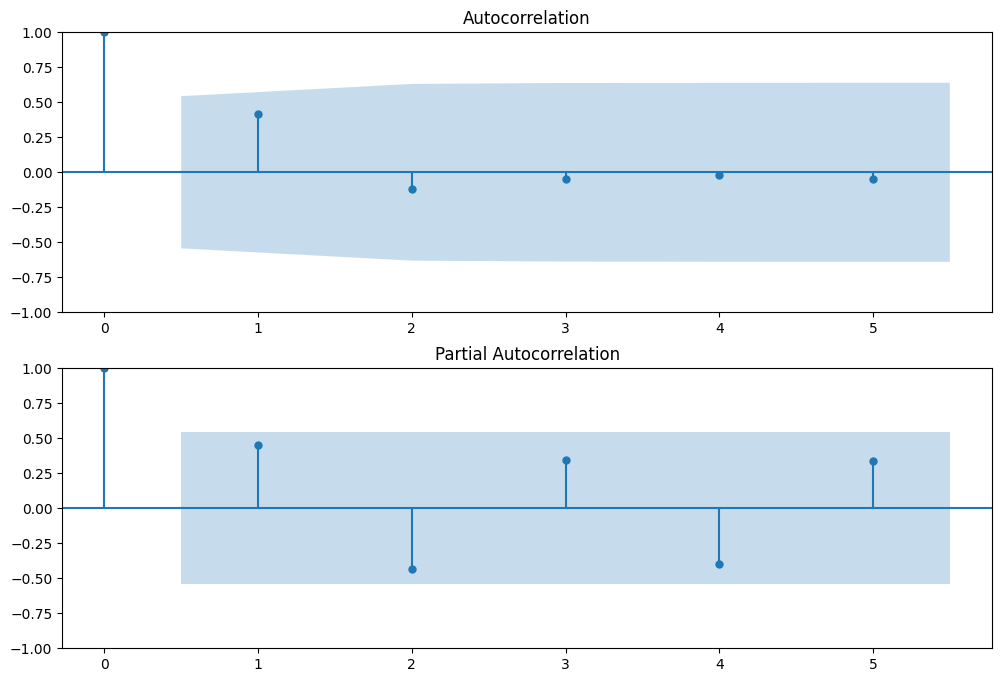

In [232]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(TXRH['sales_yoy_float'], lags=5, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(TXRH['sales_yoy_float'], lags=5, ax=ax2)

In [233]:
model_TXRH = ARIMA(TXRH["sales_yoy_float"].values, order=(1, 0, 1))
TXRH_fitted = model_TXRH.fit()
TXRH_fitted.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   13
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -47.784
Date:                Mon, 15 May 2023   AIC                            103.568
Time:                        18:54:07   BIC                            105.828
Sample:                             0   HQIC                           103.104
                                 - 13                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2330      8.117      0.768      0.443      -9.676      22.142
ar.L1         -0.0436      0.594     -0.073      0.941      -1.207       1.120
ma.L1          0.9987     47.489      0.021      0.983     -92.079      94.076
sigma2        75.0240   3535.673      0.021      0.983   -6854.768    7004.816
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 5.83
Prob(Q):                              0.83   Prob(JB):                         0.05
Heteroskedasticity (H):              22.96   Skew:                            -1.48
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

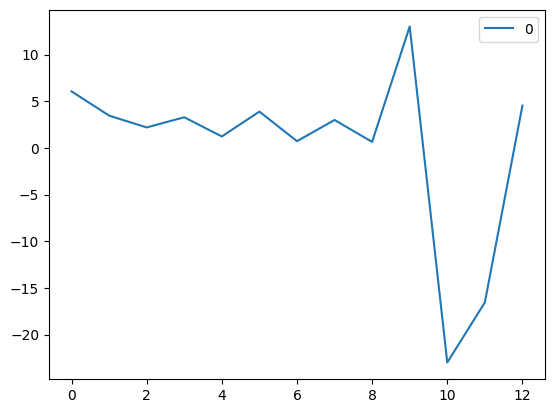

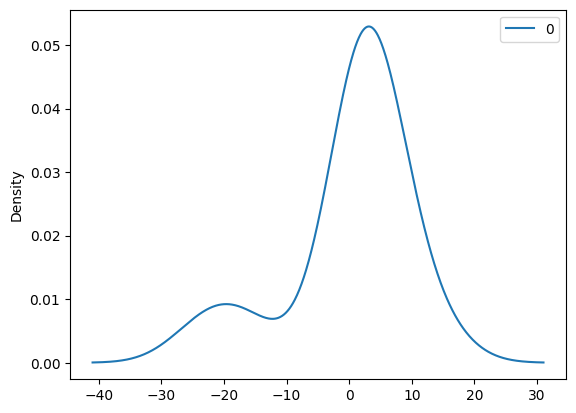

               0
count  13.000000
mean    0.195289
std     9.501963
min   -22.992540
25%     0.726121
50%     2.999203
75%     3.898456
max    13.020515


In [234]:
from matplotlib import pyplot
residuals = pd.DataFrame(TXRH_fitted.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [235]:
TXRH_fitted.predict(start=len(TXRH), end=len(TXRH))

array([10.84658158])

# **SPLIT train / test**

In [236]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

# Assuming the target variable column is named 'target'
target_column = 'sales_yoy_float'
X = df_EAT['sales_yoy_float'].dropna().values

size = int(len(X) * 0.66)
EAT_train, EAT_test = X[0:size], X[size:len(X)]

# Check for stationarity
result = adfuller(EAT_train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] > 0.05:
    print('Warning: The data is likely non-stationary.')

ADF Statistic: -11.356592
p-value: 0.000000
Critical Values:
	1%: -6.045
	5%: -3.929
	10%: -2.987


p_vaue <= 0.05, data is stationary , -> fit, predict

In [237]:
history = [x for x in EAT_train]
EAT_predictions = []

# Walk-forward validation
for t in range(len(EAT_test)):
    EAT_model = ARIMA(history, order=(1, 0, 1))
    EAT_model_fit = EAT_model.fit()
    output = EAT_model_fit.forecast()
    yhat = output[0]
    EAT_predictions.append(yhat)
    obs = EAT_test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=0.969774, expected=4.900000
predicted=4.342307, expected=11.400000


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


predicted=13.563220, expected=3.700000
predicted=-0.790845, expected=-31.300000
predicted=-40.276244, expected=-4.700000


In [238]:
EAT_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   12
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -43.398
Date:                Mon, 15 May 2023   AIC                             94.797
Time:                        18:54:07   BIC                             96.736
Sample:                             0   HQIC                            94.079
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.3244     32.661     -0.163      0.871     -69.339      58.690
ar.L1          0.4394      1.268      0.346      0.729      -2.047       2.925
ma.L1          0.9994    590.562      0.002      0.999   -1156.481    1158.480
sigma2        60.7937   3.58e+04      0.002      0.999   -7.02e+04    7.03e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):                25.36
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):              54.37   Skew:                            -2.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [239]:
# Evaluate forecasts
rmse = sqrt(mean_squared_error(EAT_test, EAT_predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 21.721


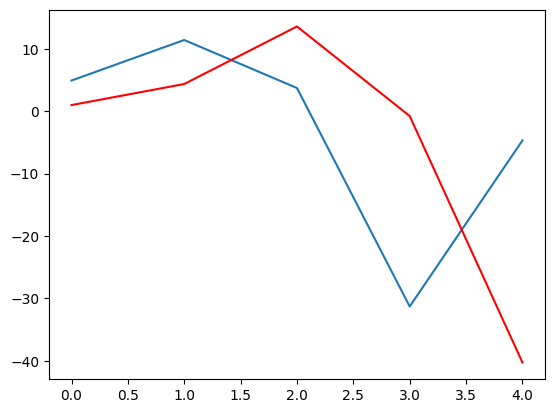

In [240]:
# Plot forecasts against actual outcomes
pyplot.plot(EAT_test)
pyplot.plot(EAT_predictions, color='red')
pyplot.show()

In [241]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

# Assuming the target variable column is named 'target'
target_column = 'sales_yoy_float'
X = df_DRI['sales_yoy_float'].dropna().values

size = int(len(X) * 0.66)
DRI_train, DRI_test = X[0:size], X[size:len(X)]

# Check for stationarity
result = adfuller(DRI_train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] > 0.05:
    print('Warning: The data is likely non-stationary.')


ADF Statistic: -2.981446
p-value: 0.036664
Critical Values:
	1%: -3.738
	5%: -2.992
	10%: -2.636


p_vaue <= 0.05, data is stationary , -> fit, predict

In [242]:
history = [x for x in DRI_train]
DRI_predictions = []

# Walk-forward validation
for t in range(len(DRI_test)):
    DRI_model = ARIMA(history, order=(1, 0, 1))
    DRI_model_fit = DRI_model.fit()
    output = DRI_model_fit.forecast()
    yhat = output[0]
    DRI_predictions.append(yhat)
    obs = DRI_test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

# Evaluate forecasts
rmse = sqrt(mean_squared_error(DRI_test, DRI_predictions))
print('Test RMSE: %.3f' % rmse)

predicted=12.298311, expected=8.100000
predicted=-2.930407, expected=12.900000
predicted=8.698920, expected=14.600000


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


predicted=4.717447, expected=13.300000
predicted=7.460090, expected=10.300000
predicted=5.454716, expected=6.500000
predicted=4.697574, expected=4.900000
predicted=4.311782, expected=5.500000
predicted=4.897355, expected=4.500000
predicted=4.028709, expected=3.500000
predicted=3.969388, expected=4.200000
predicted=4.379282, expected=4.500000
predicted=4.311485, expected=-43.000000
predicted=-21.937294, expected=-28.400000
Test RMSE: 13.805


In [243]:
DRI_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   39
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -150.653
Date:                Mon, 15 May 2023   AIC                            309.307
Time:                        18:54:09   BIC                            315.961
Sample:                             0   HQIC                           311.694
                                 - 39                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4539      5.573      0.440      0.660      -8.469      13.376
ar.L1         -0.0436      0.586     -0.074      0.941      -1.193       1.106
ma.L1          0.5719      0.497      1.150      0.250      -0.403       1.547
sigma2       131.5025     28.004      4.696      0.000      76.615     186.390
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                97.04
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.66   Skew:                            -2.40
Prob(H) (two-sided):                  0.37   Kurtosis:                         9.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

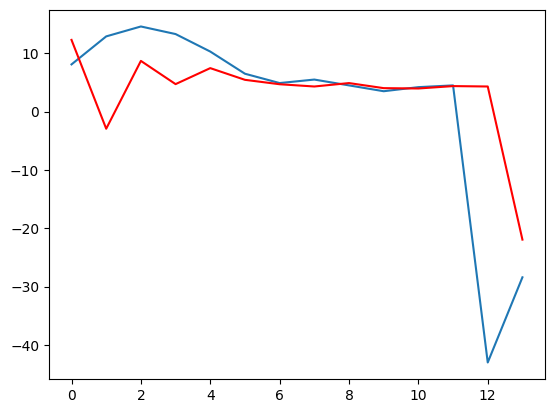

In [244]:
# Plot forecasts against actual outcomes
pyplot.plot(DRI_test)
pyplot.plot(DRI_predictions, color='red')
pyplot.show()

In [245]:
import numpy as np
from statsmodels.tsa.stattools import adfuller

target_column = 'sales_yoy_float'
X = TXRH[target_column].dropna().values

# Differencing
X_diff = np.diff(X)

size = int(len(X_diff) * 0.66)
TXRH_train, TXRH_test = X_diff[0:size], X_diff[size:len(X_diff)]

# Check for stationarity
result = adfuller(TXRH_train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -5.328160
p-value: 0.000005
Critical Values:
	1%: -5.354
	5%: -3.646
	10%: -2.901


p_vaue <= 0.05, data is stationary , -> fit, predict

In [246]:
history = [x for x in TXRH_train]
TXRH_predictions = []

# Walk-forward validation
for t in range(len(TXRH_test)):
    TXRH_model = ARIMA(history, order=(1, 0, 1))
    TXRH_model_fit = TXRH_model.fit()
    output = TXRH_model_fit.forecast()
    yhat = output[0]
    TXRH_predictions.append(yhat)
    obs = TXRH_test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

# Evaluate forecasts
rmse = sqrt(mean_squared_error(TXRH_test,TXRH_predictions))
print('Test RMSE: %.3f' % rmse)

predicted=-0.896434, expected=-0.300000
predicted=-0.416496, expected=10.300000


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=-0.357627, expected=-25.200000
predicted=28.110371, expected=-25.400000
predicted=-6.378104, expected=28.000000
Test RMSE: 30.911


In [247]:
TXRH_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   11
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -40.861
Date:                Mon, 15 May 2023   AIC                             89.721
Time:                        18:54:10   BIC                             91.313
Sample:                             0   HQIC                            88.718
                                 - 11                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9884     18.824     -0.212      0.832     -40.883      32.906
ar.L1         -0.1668      9.117     -0.018      0.985     -18.035      17.702
ma.L1          0.5220      8.205      0.064      0.949     -15.560      16.604
sigma2        97.1626     62.270      1.560      0.119     -24.884     219.210
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.56
Prob(Q):                              0.95   Prob(JB):                         0.06
Heteroskedasticity (H):              25.90   Skew:                            -1.49
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

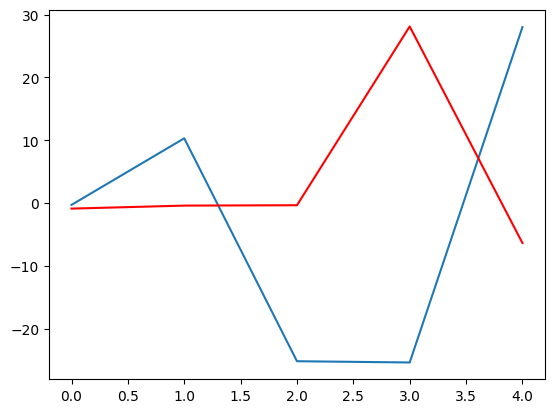

In [248]:
# Plot forecasts against actual outcomes
pyplot.plot(TXRH_test)
pyplot.plot(TXRH_predictions, color='red')
pyplot.show()